In [10]:
from dataset import GTSequenceDataset


d = GTSequenceDataset.from_sequence('../../.Datasets/DanceTrack/train/dancetrack0001/', noise_prob=0.4, noise_coeff=4)

In [1]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import random
import configparser
from copy import copy

class GTSequence:

    @staticmethod
    def compute_motion_features(bboxes):
        # velocity = np.zeros_like(bboxes)
        # acceleration = np.zeros_like(bboxes)
        # velocity[1:] = np.diff(bboxes, axis=0)
        # acceleration[2:] = np.diff(velocity[1:], axis=0)
        # # return np.concat([velocity, acceleration], axis=1).mean(axis=0).tolist()
        # velocity_center = np.sqrt(velocity[:, 0] ** 2 + velocity[:, 1] ** 2)
        # acceleration_center = np.sqrt(acceleration[:, 0] ** 2 + acceleration[:, 1] ** 2)
        # velocity_mean = velocity_center.mean()
        # velocity_std = velocity_center.std()
        # acceleration_mean = acceleration_center.mean()
        # acceleration_std = acceleration_center.std()
        # return [velocity_mean, velocity_std, acceleration_mean, acceleration_std]
        # centers = (bboxes_sequence[:, :2] + bboxes_sequence[:, 2:]) / 2
    
        centers = bboxes[:, :2]

        velocities = np.diff(centers, axis=0)
        speed = np.linalg.norm(velocities, axis=1)
        
        accelerations = np.diff(velocities, axis=0)
        acc_mag = np.linalg.norm(accelerations, axis=1)
        
        angles = np.arctan2(velocities[:, 1], velocities[:, 0])
        angle_changes = np.abs(np.diff(angles))
        angle_changes = np.minimum(angle_changes, 2*np.pi - angle_changes)
        
        # === NOISE INDICATOR FEATURES ===
        
        # 1. Jerk (3rd derivative)
        jerk = np.diff(accelerations, axis=0)
        jerk_mag = np.linalg.norm(jerk, axis=1) if len(jerk) > 0 else np.array([0])
        
        # 2. Trajectory smoothness (FIT & RESIDUALS)
        t = np.arange(len(centers))
        poly_x = np.polyfit(t, centers[:, 0], deg=3)
        poly_y = np.polyfit(t, centers[:, 1], deg=3)
        smooth_x = np.polyval(poly_x, t)
        smooth_y = np.polyval(poly_y, t)
        smooth_centers = np.column_stack([smooth_x, smooth_y])
        residuals = np.linalg.norm(centers - smooth_centers, axis=1)
        
        # 3. Size consistency
        widths = bboxes[:, 2]
        heights = bboxes[:, 3]
        areas = widths * heights
        width_changes = np.abs(np.diff(widths))
        area_changes = np.abs(np.diff(areas))
        
        # 4. Direction changes (angular acceleration)
        angle_accel = np.diff(angle_changes) if len(angle_changes) > 1 else np.array([0])
        
        # === COMBINE ALL FEATURES (16 total) ===
        descriptors = np.array([
            # Basic motion (8)
            np.mean(speed),
            np.std(speed),
            np.max(speed),
            np.mean(acc_mag),
            np.std(acc_mag),
            np.mean(angle_changes),
            np.mean(angle_changes / (speed[:-1] + 1e-6)),  # curvature
            np.std(angle_changes / (speed[:-1] + 1e-6)),
            
            # Noise indicators (8)
            np.mean(jerk_mag),                    # High jerk = noisy
            np.std(jerk_mag),
            np.mean(residuals),                   # Deviation from smooth trajectory
            np.std(residuals),
            np.std(widths) / (np.mean(widths) + 1e-6),  # Width variation
            np.mean(width_changes),               # Sudden size changes
            np.mean(area_changes) / (np.mean(areas) + 1e-6),  # Area jumps
            np.std(angle_accel) if len(angle_accel) > 0 else 0,  # Angular jerk
        ])
        
        return descriptors
        # # Velocity
        # velocities = np.diff(centers, axis=0)
        # speed = np.linalg.norm(velocities, axis=1)
        
        # # Acceleration
        # accelerations = np.diff(velocities, axis=0)
        # acc_mag = np.linalg.norm(accelerations, axis=1)
        
        # # Direction changes (angular velocity)
        # angles = np.arctan2(velocities[:, 1], velocities[:, 0])
        # angle_changes = np.abs(np.diff(angles))
        
        # # Curvature
        # curvature = angle_changes / (speed[:-1] + 1e-6)
        
        # # Descriptors (8 features instead of 4)
        # descriptors = np.array([
        #     np.mean(speed),
        #     np.std(speed),
        #     np.max(speed),
        #     np.mean(acc_mag),
        #     np.std(acc_mag),
        #     np.mean(angle_changes),
        #     np.mean(curvature),
        #     np.std(curvature),
        # ])
        # return descriptors


    @staticmethod
    def load_sequence(seq_path, seq_total_len, steps):
        sources = []

        gt_path = os.path.join(seq_path, 'gt', 'gt.txt')
        if not os.path.exists(gt_path):
            return [], []
        cfp = configparser.ConfigParser()
        cfp.read(os.path.join(seq_path, 'seqinfo.ini'))
        image_width = np.array(cfp['Sequence']['imWidth']).astype(float)
        image_height = np.array(cfp['Sequence']['imHeight']).astype(float)
        borders = np.array([image_width, image_height, image_width, image_height]).astype(float)

        df = pd.read_csv(gt_path, header=None)
        df.columns = ['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'class', 'visibility']
        
        dataset = seq_path.split('\\')[-3]
        sequence = seq_path.split('\\')[-1]

        for obj_id, obj_df in df.groupby('id'):
            obj_df = obj_df.sort_values('frame')
            obj_df['x'] += obj_df['w'] / 2
            obj_df['y'] += obj_df['h'] / 2

            bboxes = obj_df[['x', 'y', 'w', 'h']].to_numpy().astype(float)
            # bboxes /= borders

            for i in range(0, len(bboxes) - seq_total_len, steps): 
                
                seq = copy(bboxes[i:i+seq_total_len])
                # velocity_mean, velocity_std, acceleration_mean, acceleration_std = GTSequence.compute_motion_features(seq)
                # sources.append([velocity_mean, velocity_std, acceleration_mean, acceleration_std])
                features = GTSequence.compute_motion_features(seq)
                sources.append(np.concat([np.array([dataset, sequence, obj_id]), features]))

        new_df = pd.DataFrame(columns=['Dataset', 'Sequence', 'Object Id', 'Speed Mean', 'Speed Std', 'Speed Max', 'Acc Mean', 
                 'Acc Std', 'Angle Mean', 'Curv Mean', 'Curv Std',
                 'Jerk Mean', 'Jerk Std', 'Deviation From Smooth Trajectory Mean', 'Deviation From Smooth Trajectory Std',
                 'Width Variation', 'Sudden Size Changes', 'Area Jumps', 'Angular Jerk'], data=sources, index=None)

        return new_df

    @classmethod
    def from_sequence(cls, seq_path, seq_total_len=20, steps=1):
        obj = cls()
        obj.df = cls.load_sequence(seq_path, seq_total_len,steps)
        return obj
        # sources  = cls.load_sequence(seq_path, seq_total_len,steps)
        # obj.sources = np.array(sources, dtype=np.float32)
        # return obj
    

    @classmethod
    def from_roots(cls, root_dirs, seq_total_len=20, steps=1):
        obj = cls()
        dfs = []
        for root in root_dirs:
            sequences = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
            for seq_path in sequences:
                dfs.append(cls.load_sequence(seq_path, seq_total_len, steps))
        obj.df = pd.concat(dfs)
        return obj
        # sources = []
        # for root in root_dirs:
        #     sequences = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        #     for seq_path in sequences:
        #         sources_ = cls.load_sequence(seq_path, seq_total_len, steps)
        #         sources.extend(sources_)

        # obj = cls()
        # obj.sources = np.array(sources, dtype=np.float32)
        # return obj
    
# d = GTSequence.from_sequence('../../.Datasets/DanceTrack/train/dancetrack0001/', 20, 1)

BASE_DIR = '..\\..\\.Datasets\\'
# d = GTSequence.from_sequence('../../.Datasets/DanceTrack/train/dancetrack0001/', seq_total_len=30, steps=10)
d = GTSequence.from_roots([
    # f'{BASE_DIR}DanceTrack\\train',
    f'{BASE_DIR}SportsMOT\\train',
    f'{BASE_DIR}MOT17\\train',
    f'{BASE_DIR}MOT20\\train',
], 60, 60)

In [15]:
# d.df['label'] = hierarchical_labels
d.df['label'] = rule_based_labels
# d.df['label'] = labels_best

In [16]:
d.df

,Dataset,Sequence,Object Id,Speed Mean,Speed Std,Speed Max,Acc Mean,Acc Std,Angle Mean,Curv Mean,Curv Std,Jerk Mean,Jerk Std,Deviation From Smooth Trajectory Mean,Deviation From Smooth Trajectory Std,Width Variation,Sudden Size Changes,Area Jumps,Angular Jerk,label
0,DanceTrack,dancetrack0001,0,5.026141165152203,4.278021074047714,18.681541692269406,5.48892352164516,3.9584254908528917,1.1357661187948458,0.6404404859447113,0.8760334848430866,8.937234576824174,6.484695576147709,12.987917922890468,7.443947877598535,0.25350611857631317,8.084745762711865,0.0751667355156735,1.2971220619130168,4
1,DanceTrack,dancetrack0001,0,5.318828647265462,4.490845013989275,16.00781059358212,4.780394750018763,3.6378610378276925,0.8739996740697411,73254.66567626657,401023.442681656,7.640413670836404,6.222585488891765,17.739851720581125,11.014384676197547,0.3328508912917375,8.101694915254237,0.07011048419116685,1.049128083469281,8
2,DanceTrack,dancetrack0001,0,2.806311781743675,4.665237903057165,31.51586901863885,2.889692187514386,3.671726516659766,1.2623562567379791,135414.60511287808,603767.7278974241,4.578275529365068,4.910149551267608,3.42017002827494,4.340852159633241,0.21432624768730127,4.864406779661017,0.03404241877275687,1.3991783893690226,4
3,DanceTrack,dancetrack0001,0,5.120454998571961,4.770274298065664,25.578311124857326,4.647131688249242,3.7207287249252037,0.9156230397867351,718.5941186735339,5420.5143258996295,7.4321828467976845,5.420836203881291,15.62932859299127,9.379877287693914,0.2534604635996559,5.203389830508475,0.0446358080691168,1.298868265302552,8
4,DanceTrack,dancetrack0001,0,6.2943296515773834,9.633982438592268,48.59269492423733,6.238622967941287,8.913488268856804,0.9008650947384417,200674.4947802017,563218.8706219075,10.76494466181122,15.566698647401745,9.22545988160729,7.887295119998399,0.20529904569596252,5.898305084745763,0.04029073541466786,0.8918558522453295,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11934,MOT20,MOT20-05,1211,2.67607194478284,0.3560541244902663,3.5355339059327378,0.7274462639150712,0.5880662659224763,0.21080063011728722,0.07646377629195727,0.06683740081989072,1.3291191787946377,0.8461077643605134,1.67452955872223,1.6571495339614895,0.012657061440087367,0.1864406779661017,0.008957070086595591,0.28859670727789116,3
11935,MOT20,MOT20-05,1211,2.2975964095156645,0.47908800366103416,3.5,0.6323984611439502,0.3296860263916811,0.16391849904911202,0.07802879954502642,0.08283241669939341,1.153159646716778,0.5953430569846475,0.9618305353932688,0.46690267871321955,0.10814268054360698,0.5084745762711864,0.010425856224661535,0.18132031751144673,3
11936,MOT20,MOT20-05,1211,2.682677211814606,0.5658552197806311,3.640054944640259,0.7345164817083432,0.6393445082017697,0.1890527731915871,0.07137261863203097,0.08455428381334389,1.419644600137251,1.0162946537969353,2.059297205127469,1.2887906308801194,0.0570801609913394,0.5084745762711864,0.009039122381515349,0.2700795265014395,3
11937,MOT20,MOT20-05,1211,1.8192604050533443,0.48672553672133084,2.23606797749979,0.9088967885378716,0.5848162754758159,0.3231872498970184,0.20799150054435167,0.19319051163840867,1.7642944769128623,0.7049213584094236,0.808438470723161,0.47380635038696217,0.0,0.0,0.000603602298449312,0.3868614795429614,3


In [12]:
df['Sudden Size Changes']

0          8.084745762711865
1          7.694915254237288
2          8.491525423728813
3          8.796610169491526
4          9.186440677966102
                ...         
68709    0.13559322033898305
68710    0.13559322033898305
68711    0.13559322033898305
68712     0.1016949152542373
68713    0.06779661016949153
Name: Sudden Size Changes, Length: 125719, dtype: object

In [22]:
df = d.df
df[df['Dataset'] == 'SportsMOT']['label'].value_counts()
# df[df['Dataset'] == 'DanceTrack']['label'].value_counts()
# df[df['Dataset'] == 'MOT17']['label'].value_counts()
# df[df['Dataset'] == 'MOT20']['label'].value_counts()

label
8    1830
4    1693
9    1138
7     121
5      70
1      19
0      17
Name: count, dtype: int64

In [37]:
new_df = d.df[d.df['label'] == 1]

In [33]:
h = df[df['Dataset'] == 'SportsMOT']
h[h['label'] == 0][['Sequence', 'Object Id']].value_counts()
# h = df[df['Dataset'] == 'MOT17']
# h[h['label'] == 1][['Sequence', 'Object Id']].value_counts()

Sequence            Object Id
v_1yHWGw8DH4A_c077  6            95
v_gQNyhv8y0QY_c012  6            92
                    11           88
                    8            88
                    4            87
                                 ..
v_iIxMOsCGH58_c013  21            3
v_1yHWGw8DH4A_c601  17            2
v_HdiyOtliFiw_c008  11            2
v_gQNyhv8y0QY_c003  18            1
v_1yHWGw8DH4A_c609  3             1
Name: count, Length: 619, dtype: int64

In [17]:
kmeans_best.cluster_centers_

array([[-0.40588053, -0.4034967 , -0.35690224, -0.44643291, -0.37096003,
        -0.21759572,  0.14136964,  0.14372915, -0.43948891, -0.36291205,
        -0.42511405, -0.41310389, -0.41886427, -0.44638897, -0.46006673,
        -0.23325242],
       [ 1.47842133,  1.46973822,  1.30001772,  1.62613353,  1.35122327,
         0.7925932 , -0.51493942, -0.52353397,  1.60083999,  1.32190848,
         1.54847948,  1.50473246,  1.52571466,  1.62597346,  1.67579477,
         0.84962281]])

In [2]:
# X = new_df[new_df.columns[3:]].to_numpy().astype(float)
X = d.df[d.df.columns[3:]].to_numpy().astype(float)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# CRITICAL: Standardize features before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("After standardization:")
print(f"Feature means: {X_scaled.mean(axis=0).round(3)}")
print(f"Feature stds: {X_scaled.std(axis=0).round(3)}")
print("\nNow all features are on the same scale!\n")

# Now cluster with standardized data
print("Testing different k values with STANDARDIZED features:\n")
for k in range(2, 11):
# for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=30000)
    labels = kmeans.fit_predict(X_scaled)
    
    # Sample for silhouette
    idx = np.random.choice(len(X_scaled), size=10000, replace=False)
    sil = silhouette_score(X_scaled[idx], labels[idx])
    
    cluster_sizes = np.bincount(labels)
    print(f"k={k:2d}: silhouette={sil:.4f}, inertia={kmeans.inertia_:8.1f}")
    print(f"      cluster sizes: {cluster_sizes}\n")

After standardization:
Feature means: [ 0.  0. -0.  0. -0. -0. -0.  0. -0.  0. -0. -0.  0.  0. -0. -0.]
Feature stds: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Now all features are on the same scale!

Testing different k values with STANDARDIZED features:

k= 2: silhouette=0.4775, inertia=266991.1
      cluster sizes: [ 6617 20120]

k= 3: silhouette=0.3970, inertia=211553.0
      cluster sizes: [14212  6315  6210]

k= 4: silhouette=0.4299, inertia=164088.7
      cluster sizes: [ 7151  5743 12644  1199]

k= 5: silhouette=0.4330, inertia=131690.5
      cluster sizes: [12404  5681  1603  7029    20]

k= 6: silhouette=0.4269, inertia=116098.1
      cluster sizes: [12091  2308  6542  5570   215    11]

k= 7: silhouette=0.3958, inertia=105033.3
      cluster sizes: [11129  1410  5481  4240   161    11  4305]

k= 8: silhouette=0.3556, inertia= 95198.3
      cluster sizes: [9856 3746 4698 2524   11 1195  134 4573]

k= 9: silhouette=0.3573, inertia= 88108.0
      cluster sizes: [3067 4

In [9]:
# Use k=3 (or k=4 if you prefer)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_k = 8

# Fit on standardized data
kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=30, max_iter=10000)
labels_best = kmeans_best.fit_predict(X_scaled)

print(f"Using k={best_k}")
print(f"Cluster sizes: {np.bincount(labels_best)}")

Using k=8
Cluster sizes: [9324 1428 4392    7   88    2 2408 3474]


In [3]:
# NEW CELL: Rule-Based Multi-Class Categorization
# This creates more fine-grained motion categories using thresholds

import numpy as np

def categorize_motion_detailed(features_array):
    """
    Create detailed motion categories based on multiple feature thresholds.
    Returns category labels and category names.
    
    Features (16 total):
    0-7: Basic motion (Speed Mean/Std/Max, Acc Mean/Std, Angle Mean, Curv Mean/Std)
    8-15: Noise indicators (Jerk, Trajectory deviation, Size consistency, etc.)
    """
    
    # Extract key features
    speed_mean = features_array[:, 0]
    speed_std = features_array[:, 1]
    speed_max = features_array[:, 2]
    acc_mean = features_array[:, 3]
    acc_std = features_array[:, 4]
    angle_mean = features_array[:, 5]
    jerk_mean = features_array[:, 8]
    trajectory_deviation = features_array[:, 10]  # Deviation from smooth
    width_variation = features_array[:, 12]
    area_jumps = features_array[:, 14]
    
    # Compute percentiles for thresholds
    speed_25, speed_75 = np.percentile(speed_mean, [25, 75])
    speed_std_median = np.median(speed_std)
    acc_75 = np.percentile(acc_mean, 75)
    angle_median = np.median(angle_mean)
    jerk_75 = np.percentile(jerk_mean, 75)
    trajectory_dev_75 = np.percentile(trajectory_deviation, 75)
    
    # Initialize labels
    n_samples = len(features_array)
    labels = np.zeros(n_samples, dtype=int)
    
    # Define categories (0-9 for 10 categories)
    for i in range(n_samples):
        speed = speed_mean[i]
        speed_var = speed_std[i]
        acc = acc_mean[i]
        jerk = jerk_mean[i]
        traj_dev = trajectory_deviation[i]
        angle_change = angle_mean[i]
        
        # 1. STATIONARY/VERY SLOW (low speed, low variance)
        if speed < speed_25 and speed_var < speed_std_median:
            labels[i] = 0
            
        # 2. SLOW STEADY (low speed, low acceleration)
        elif speed < speed_25 and acc < acc_75:
            labels[i] = 1
            
        # 3. SLOW NOISY (low speed, high trajectory deviation)
        elif speed < speed_25 and traj_dev > trajectory_dev_75:
            labels[i] = 2
            
        # 4. MEDIUM LINEAR (medium speed, low variance, low angle changes)
        elif speed_25 <= speed < speed_75 and speed_var < speed_std_median and angle_change < angle_median:
            labels[i] = 3
            
        # 5. MEDIUM CURVED (medium speed, high angle changes)
        elif speed_25 <= speed < speed_75 and angle_change >= angle_median:
            labels[i] = 4
            
        # 6. MEDIUM ERRATIC (medium speed, high acceleration/jerk)
        elif speed_25 <= speed < speed_75 and (acc > acc_75 or jerk > jerk_75):
            labels[i] = 5
            
        # 7. FAST LINEAR (high speed, low variance, low angle changes)
        elif speed >= speed_75 and speed_var < speed_std_median and angle_change < angle_median:
            labels[i] = 6
            
        # 8. FAST CURVED (high speed, high angle changes)
        elif speed >= speed_75 and angle_change >= angle_median and jerk < jerk_75:
            labels[i] = 7
            
        # 9. FAST ERRATIC (high speed, high jerk/deviation)
        elif speed >= speed_75 and (jerk >= jerk_75 or traj_dev > trajectory_dev_75):
            labels[i] = 8
            
        # 10. COMPLEX (everything else)
        else:
            labels[i] = 9
    
    # Category names
    category_names = {
        0: "🐌 STATIONARY/VERY_SLOW",
        1: "🚶 SLOW_STEADY",
        2: "📍 SLOW_NOISY",
        3: "➡️  MEDIUM_LINEAR",
        4: "🔄 MEDIUM_CURVED",
        5: "🎢 MEDIUM_ERRATIC",
        6: "🏃 FAST_LINEAR",
        7: "🏂 FAST_CURVED",
        8: "💥 FAST_ERRATIC",
        9: "🔀 COMPLEX"
    }
    
    return labels, category_names


# Apply rule-based categorization
print("Applying rule-based categorization...")
rule_based_labels, category_names = categorize_motion_detailed(X)

print(f"\nFound {len(np.unique(rule_based_labels))} distinct motion categories")
print(f"Category distribution:")
print("="*70)

for cat_id in sorted(np.unique(rule_based_labels)):
    count = np.sum(rule_based_labels == cat_id)
    percentage = count / len(rule_based_labels) * 100
    print(f"{category_names[cat_id]:30s}: {count:6,} samples ({percentage:5.1f}%)")

Applying rule-based categorization...

Found 9 distinct motion categories
Category distribution:
🐌 STATIONARY/VERY_SLOW        :  4,925 samples ( 23.3%)
🚶 SLOW_STEADY                 :    354 samples (  1.7%)
➡️  MEDIUM_LINEAR             :  3,487 samples ( 16.5%)
🔄 MEDIUM_CURVED               :  4,228 samples ( 20.0%)
🎢 MEDIUM_ERRATIC              :     79 samples (  0.4%)
🏃 FAST_LINEAR                 :    137 samples (  0.6%)
🏂 FAST_CURVED                 :     10 samples (  0.0%)
💥 FAST_ERRATIC                :  4,375 samples ( 20.7%)
🔀 COMPLEX                     :  3,528 samples ( 16.7%)


In [14]:
rule_based_labels

array([4, 8, 4, ..., 3, 3, 3])

In [ ]:
best_k = 4
# labels_best = spectral_labels

In [41]:
# NEW CELL: Detailed Mapping - Which Categories are in Each KMeans Cluster

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("="*90)
print("DETAILED CLUSTER → CATEGORY MAPPING")
print("="*90)

# Create confusion-style matrix
n_kmeans_clusters = best_k
unique_categories = list(np.unique(rule_based_labels))
n_rule_categories = len(unique_categories)
# n_rule_categories = len(np.unique(rule_based_labels))

# Count matrix: [kmeans_cluster, rule_category] = count
count_matrix = np.zeros((n_kmeans_clusters, n_rule_categories))
for k_cluster in range(n_kmeans_clusters):
    for i, r_category in enumerate(unique_categories):
    # for r_category in range(n_rule_categories):
        count_matrix[k_cluster, i] = np.sum(
        # count_matrix[k_cluster, r_category] = np.sum(
            (labels_best == k_cluster) & (rule_based_labels == r_category)
        )

# Convert to percentages (row-wise: what % of each KMeans cluster is each category)
pct_matrix_row = count_matrix / count_matrix.sum(axis=1, keepdims=True) * 100

# Also compute column-wise: what % of each category is in each KMeans cluster
pct_matrix_col = count_matrix / count_matrix.sum(axis=0, keepdims=True) * 100

print("\n" + "="*90)
print("1. COMPOSITION OF EACH KMEANS CLUSTER (Row Percentages)")
print("   → What rule-based categories make up each KMeans cluster?")
print("="*90)

for k_cluster in range(n_kmeans_clusters):
    cluster_size = labels_best[labels_best == k_cluster].shape[0]
    print(f"\n{'='*90}")
    print(f"KMeans Cluster {k_cluster} ({cluster_size:,} samples total)")
    print(f"{'='*90}")
    
    # Get categories sorted by percentage in this cluster
    category_percentages = []
    for i, r_category in enumerate(unique_categories):
        pct = pct_matrix_row[k_cluster, i]
        count = int(count_matrix[k_cluster, i])
        # pct = pct_matrix_row[k_cluster, r_category]
        # count = int(count_matrix[k_cluster, r_category])
        category_percentages.append((r_category, pct, count))
    
    category_percentages.sort(key=lambda x: x[1], reverse=True)
    
    # Show all categories
    for r_category, pct, count in category_percentages:
        if pct > 0.1:  # Only show categories with >0.1%
            bar = '█' * int(pct / 2)  # Visual bar
            print(f"  {category_names[r_category]:30s}: {pct:5.1f}% │{bar} │ ({count:,} samples)")
    
    # Identify dominant categories (>20%)
    dominant = [cat for cat, pct, _ in category_percentages if pct > 20]
    if dominant:
        dominant_names = [category_names[cat] for cat in dominant]
        print(f"\n  🎯 DOMINANT TYPES: {', '.join(dominant_names)}")

print("\n\n" + "="*90)
print("2. WHERE EACH RULE-BASED CATEGORY ENDED UP (Column Percentages)")
print("   → Which KMeans cluster contains each motion category?")
print("="*90)

for i, r_category in enumerate(unique_categories):
# for r_category in range(n_rule_categories):
    category_total = rule_based_labels[rule_based_labels == r_category].shape[0]
    print(f"\n{category_names[r_category]} ({category_total:,} samples total):")
    
    for k_cluster in range(n_kmeans_clusters):
        pct = pct_matrix_col[k_cluster, i]
        count = int(count_matrix[k_cluster, i])
        if pct > 0.1:
            bar = '█' * int(pct / 2)
            print(f"  KMeans Cluster {k_cluster}: {pct:5.1f}% │{bar} │ ({count:,} samples)")

DETAILED CLUSTER → CATEGORY MAPPING

1. COMPOSITION OF EACH KMEANS CLUSTER (Row Percentages)
   → What rule-based categories make up each KMeans cluster?

KMeans Cluster 0 (17,087 samples total)
  🐌 STATIONARY/VERY_SLOW        :  28.8% │██████████████ │ (4,925 samples)
  🔄 MEDIUM_CURVED               :  21.9% │██████████ │ (3,749 samples)
  🔀 COMPLEX                     :  20.6% │██████████ │ (3,517 samples)
  ➡️  MEDIUM_LINEAR             :  20.4% │██████████ │ (3,487 samples)
  💥 FAST_ERRATIC                :   4.9% │██ │ (837 samples)
  🚶 SLOW_STEADY                 :   2.1% │█ │ (354 samples)
  🏃 FAST_LINEAR                 :   0.8% │ │ (137 samples)
  🎢 MEDIUM_ERRATIC              :   0.4% │ │ (71 samples)

  🎯 DOMINANT TYPES: 🐌 STATIONARY/VERY_SLOW, 🔄 MEDIUM_CURVED, 🔀 COMPLEX, ➡️  MEDIUM_LINEAR

KMeans Cluster 1 (4,036 samples total)
  💥 FAST_ERRATIC                :  87.7% │███████████████████████████████████████████ │ (3,538 samples)
  🔄 MEDIUM_CURVED               :  11.9% │██

In [43]:
count_matrix.astype(int)

array([[   0,    0,    0,    0,   10,    2,    0,    0, 1779],
       [5406,  126,    0,  102,  534,    0,    0,    0,    0],
       [  77,   22,    0,  242, 3378,   72,    3,  139, 3947],
       [1042,   11,    0, 5741,  447,    0,   35,    0,   36]])

In [38]:
r_category

np.int64(9)

In [35]:
pct_matrix_col.shape

(4, 9)

In [16]:
# NEW CELL: Hierarchical Clustering for Better Separation

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

print("="*80)
print("HIERARCHICAL CLUSTERING - Better Category Separation")
print("="*80)

# Try different linkage methods
linkage_methods = ['complete']
# linkage_methods = ['ward', 'average', 'complete']
best_purity = 0
best_method = None
best_labels = None

for method in linkage_methods:
    print(f"\nTrying linkage='{method}'...")
    
    # Fit hierarchical clustering
    hierarchical = AgglomerativeClustering(
        n_clusters=3,  # Try more clusters for better separation
        linkage=method
    )
    h_labels = hierarchical.fit_predict(X_scaled)
    
    # Compute cluster purity (how well clusters match rule-based categories)
    purity = 0
    for cluster_id in range(4):
        cluster_mask = h_labels == cluster_id
        if cluster_mask.sum() > 0:
            # Find most common rule-based category in this cluster
            rule_labels_in_cluster = rule_based_labels[cluster_mask]
            most_common = np.bincount(rule_labels_in_cluster).max()
            cluster_purity = most_common / cluster_mask.sum()
            purity += cluster_purity * cluster_mask.sum() / len(h_labels)
    
    sil = silhouette_score(X_scaled[:20000], h_labels[:20000])
    
    print(f"  Silhouette: {sil:.4f}")
    print(f"  Purity: {purity:.4f} (higher = cleaner clusters)")
    print(f"  Cluster sizes: {np.bincount(h_labels)}")
    
    if purity > best_purity:
        best_purity = purity
        best_method = method
        best_labels = h_labels

print(f"\n{'='*80}")
print(f"Best method: {best_method} with purity={best_purity:.4f}")
print(f"{'='*80}")

# Use best hierarchical labels
hierarchical_labels = best_labels

HIERARCHICAL CLUSTERING - Better Category Separation

Trying linkage='complete'...
  Silhouette: 0.9391
  Purity: 0.2336 (higher = cleaner clusters)
  Cluster sizes: [    2 21114     7]

Best method: complete with purity=0.2336


In [19]:
# NEW CELL: Feature-Weighted KMeans
feature_names = ['Speed Mean', 'Speed Std', 'Speed Max', 'Acc Mean', 
                 'Acc Std', 'Angle Mean', 'Curv Mean', 'Curv Std',
                 'Jerk Mean', 'Jerk Std', 'Traj Dev Mean', 'Traj Dev Std',
                 'Width Var', 'Size Changes', 'Area Jumps', 'Angular Jerk']


print("="*80)
print("FEATURE-WEIGHTED KMEANS")
print("="*80)

# Identify which features best separate the rule-based categories
from sklearn.feature_selection import mutual_info_classif

# Compute mutual information between features and rule-based labels
mi_scores = mutual_info_classif(X_scaled, rule_based_labels, random_state=42)

print("\nFeature Importance (Mutual Information):")
for i, (name, score) in enumerate(zip(feature_names, mi_scores)):
    print(f"  {name:30s}: {score:.4f}")

# Weight features by their MI scores (normalize)
feature_weights = mi_scores / mi_scores.max()
print(f"\nFeature weights: {feature_weights}")

# Apply weights to scaled features
X_weighted = X_scaled * feature_weights

# Cluster on weighted features
print("\nClustering with weighted features...")
weighted_kmeans = KMeans(n_clusters=2, random_state=42, n_init=10, max_iter=300)
weighted_labels = weighted_kmeans.fit_predict(X_weighted)

# Evaluate
purity = 0
for cluster_id in range(4):
    cluster_mask = weighted_labels == cluster_id
    if cluster_mask.sum() > 0:
        rule_labels_in_cluster = rule_based_labels[cluster_mask]
        most_common = np.bincount(rule_labels_in_cluster).max()
        cluster_purity = most_common / cluster_mask.sum()
        purity += cluster_purity * cluster_mask.sum() / len(weighted_labels)

sil = silhouette_score(X_weighted[:20000], weighted_labels[:20000])

print(f"\nWeighted KMeans Results:")
print(f"  Silhouette: {sil:.4f}")
print(f"  Purity: {purity:.4f}")
print(f"  Cluster sizes: {np.bincount(weighted_labels)}")

FEATURE-WEIGHTED KMEANS

Feature Importance (Mutual Information):
  Speed Mean                    : 1.0986
  Speed Std                     : 0.9060
  Speed Max                     : 0.9927
  Acc Mean                      : 0.6550
  Acc Std                       : 0.5492
  Angle Mean                    : 0.7069
  Curv Mean                     : 0.7297
  Curv Std                      : 0.6824
  Jerk Mean                     : 0.6426
  Jerk Std                      : 0.5049
  Traj Dev Mean                 : 0.7192
  Traj Dev Std                  : 0.6830
  Width Var                     : 0.3771
  Size Changes                  : 0.4597
  Area Jumps                    : 0.4860
  Angular Jerk                  : 0.5677

Feature weights: [1.         0.82469129 0.90360921 0.59625849 0.49986926 0.64342695
 0.66420185 0.62115158 0.58492491 0.4596167  0.65465898 0.62171236
 0.34326666 0.41846568 0.44234208 0.51676094]

Clustering with weighted features...

Weighted KMeans Results:
  Silhouette: 0.

In [60]:
# NEW CELL: Spectral Clustering

from sklearn.cluster import SpectralClustering

print("="*80)
print("SPECTRAL CLUSTERING")
print("="*80)

# Spectral clustering works better with non-Euclidean structure
spectral = SpectralClustering(
    n_clusters=4,
    affinity='nearest_neighbors',  # Use neighbor graph
    n_neighbors=30,
    assign_labels='kmeans',
    # random_state=42
)

print("Fitting Spectral Clustering (this may take a minute)...")
spectral_labels = spectral.fit_predict(X_scaled)

# Evaluate
sil = silhouette_score(X_scaled[:20000], spectral_labels[:20000])

# Compute purity
purity = 0
for cluster_id in range(5):
    cluster_mask = spectral_labels == cluster_id
    if cluster_mask.sum() > 0:
        rule_labels_in_cluster = rule_based_labels[cluster_mask]
        most_common = np.bincount(rule_labels_in_cluster).max()
        cluster_purity = most_common / cluster_mask.sum()
        purity += cluster_purity * cluster_mask.sum() / len(spectral_labels)

print(f"\nSpectral Clustering Results:")
print(f"  Silhouette: {sil:.4f}")
print(f"  Purity: {purity:.4f}")
print(f"  Cluster sizes: {np.bincount(spectral_labels)}")

SPECTRAL CLUSTERING
Fitting Spectral Clustering (this may take a minute)...

Spectral Clustering Results:
  Silhouette: 0.1586
  Purity: 0.6477
  Cluster sizes: [10633  9719   224  6161]


In [15]:
X_scaled.shape

(161883, 16)

In [8]:
# NEW CELL: Detailed Rule-Based Cluster Analysis

feature_names = ['Speed Mean', 'Speed Std', 'Speed Max', 'Acc Mean', 
                 'Acc Std', 'Angle Mean', 'Curv Mean', 'Curv Std',
                 'Jerk Mean', 'Jerk Std', 'Traj Dev Mean', 'Traj Dev Std',
                 'Width Var', 'Size Changes', 'Area Jumps', 'Angular Jerk']

print("\n" + "="*80)
print("RULE-BASED CLUSTER INTERPRETATION (10 CATEGORIES)")
print("="*80)

for cluster_id in sorted(np.unique(rule_based_labels)):
    cluster_mask = rule_based_labels == cluster_id
    cluster_data = X[cluster_mask]
    
    print(f"\n{'='*80}")
    print(f"{category_names[cluster_id]} (ID: {cluster_id})")
    print(f"{cluster_mask.sum():,} samples ({cluster_mask.sum()/len(X)*100:.1f}%)")
    print(f"{'='*80}")
    
    # Show only the most relevant features (top 5 most distinctive)
    # Compute z-scores relative to overall distribution
    feature_zscores = []
    for i in range(len(feature_names)):
        feat_mean = cluster_data[:, i].mean()
        overall_mean = X[:, i].mean()
        overall_std = X[:, i].std()
        z_score = (feat_mean - overall_mean) / (overall_std + 1e-10)
        feature_zscores.append((i, abs(z_score), z_score, feat_mean))
    
    # Sort by absolute z-score
    feature_zscores.sort(key=lambda x: x[1], reverse=True)
    
    print("\nTop 5 Distinctive Features:")
    for idx, abs_z, z, mean_val in feature_zscores[:5]:
        direction = "↑" if z > 0 else "↓"
        print(f"  {direction} {feature_names[idx]:30s}: {mean_val:8.2f} (z={z:+.2f})")
    
    # Show representative statistics
    print("\nKey Statistics:")
    print(f"  Speed: {cluster_data[:, 0].mean():6.2f} px/frame (std: {cluster_data[:, 1].mean():5.2f})")
    print(f"  Acceleration: {cluster_data[:, 3].mean():6.2f} px/frame²")
    print(f"  Trajectory Noise: {cluster_data[:, 10].mean():6.2f} px")
    print(f"  Jerk: {cluster_data[:, 8].mean():6.2f}")


RULE-BASED CLUSTER INTERPRETATION (10 CATEGORIES)

🐌 STATIONARY/VERY_SLOW (ID: 0)
38,931 samples (24.0%)

Top 5 Distinctive Features:
  ↑ Curv Std                      : 552742.16 (z=+1.07)
  ↑ Curv Mean                     : 254123.72 (z=+1.05)
  ↓ Speed Mean                    :     0.36 (z=-0.79)
  ↓ Width Var                     :     0.01 (z=-0.75)
  ↓ Area Jumps                    :     0.00 (z=-0.73)

Key Statistics:
  Speed:   0.36 px/frame (std:  0.35)
  Acceleration:   0.47 px/frame²
  Trajectory Noise:   0.29 px
  Jerk:   0.91

🚶 SLOW_STEADY (ID: 1)
1,540 samples (1.0%)

Top 5 Distinctive Features:
  ↑ Curv Std                      : 618343.35 (z=+1.27)
  ↑ Curv Mean                     : 280548.97 (z=+1.21)
  ↑ Angle Mean                    :     0.92 (z=+0.80)
  ↑ Angular Jerk                  :     1.04 (z=+0.74)
  ↓ Speed Mean                    :     0.73 (z=-0.70)

Key Statistics:
  Speed:   0.73 px/frame (std:  0.72)
  Acceleration:   0.82 px/frame²
  Trajectory Nois

In [ ]:
# NEW CELL: Visualize Rule-Based Categories

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA on standardized data
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

# Create figure with better colors for 10 categories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: All categories
scatter1 = ax1.scatter(X_2d[:, 0], X_2d[:, 1], c=rule_based_labels, 
                      cmap='tab10', alpha=0.5, s=8, edgecolors='none')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax1.set_title('Rule-Based Motion Categories (10 Classes)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=plt.cm.tab10(i/10), label=category_names[i]) 
                   for i in sorted(np.unique(rule_based_labels))]
ax1.legend(handles=legend_elements, loc='best', fontsize=9)

# Plot 2: Speed-based coloring for validation
speed_colors = X[:, 0]  # Speed mean
scatter2 = ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=speed_colors, 
                      cmap='YlOrRd', alpha=0.5, s=8, edgecolors='none')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax2.set_title('Speed Distribution (for validation)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Speed (px/frame)')

plt.tight_layout()
plt.savefig('rule_based_motion_categories.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPCA explains {pca.explained_variance_ratio_.sum():.1%} of variance")

In [10]:
# Analyze what each cluster represents
feature_names = ['Speed Mean', 'Speed Std', 'Speed Max', 'Acc Mean', 
                 'Acc Std', 'Angle Mean', 'Curv Mean', 'Curv Std',
                 'Jerk Mean', 'Jerk Std', 'Deviation From Smooth Trajectory Mean', 'Deviation From Smooth Trajectory Std',
                 'Width Variation', 'Sudden Size Changes', 'Area Jumps', 'Angular Jerk']

print("\n" + "="*70)
print("CLUSTER INTERPRETATION")
print("="*70)

for cluster_id in range(best_k):
    cluster_mask = labels_best == cluster_id
    cluster_data = X[cluster_mask]  # Use ORIGINAL (not scaled) for interpretation
    
    print(f"\n{'='*70}")
    print(f"Cluster {cluster_id} - {cluster_mask.sum():,} samples ({cluster_mask.sum()/len(X)*100:.1f}%)")
    print(f"{'='*70}")
    
    for i, name in enumerate(feature_names):
        feat_mean = cluster_data[:, i].mean()
        feat_std = cluster_data[:, i].std()
        
        # Compare to overall mean
        overall_mean = X[:, i].mean()
        diff_pct = (feat_mean - overall_mean) / (overall_mean + 1e-10) * 100
        
        marker = ""
        if abs(diff_pct) > 50:
            marker = " ⭐" if diff_pct > 0 else " 🔻"
        
        print(f"  {name:15s}: {feat_mean:8.2f} ± {feat_std:6.2f}  ({diff_pct:+6.1f}%){marker}")
    
    # Label the cluster based on characteristics
    speed_mean = cluster_data[:, 0].mean()
    speed_std = cluster_data[:, 1].mean()
    acc_mean = cluster_data[:, 3].mean()
    
    # Simple heuristic labeling
    if speed_mean < X[:, 0].mean() * 0.5:
        label = "🐌 SLOW/STATIONARY"
    elif speed_std < X[:, 1].mean() * 0.5:
        label = "➡️  LINEAR (smooth)"
    elif acc_mean > X[:, 3].mean() * 1.5:
        label = "🎢 ERRATIC (high accel)"
    else:
        label = "🔄 COMPLEX"
    
    print(f"\n  → Motion Type: {label}")


CLUSTER INTERPRETATION

Cluster 0 - 127,447 samples (78.7%)
  Speed Mean     :     2.12 ±   2.05  ( -41.2%)
  Speed Std      :     0.92 ±   1.02  ( -59.0%) 🔻
  Speed Max      :     4.29 ±   4.39  ( -58.3%) 🔻
  Acc Mean       :     1.11 ±   1.04  ( -58.0%) 🔻
  Acc Std        :     0.81 ±   0.81  ( -63.5%) 🔻
  Angle Mean     :     0.52 ±   0.42  ( -10.9%)
  Curv Mean      : 100390.32 ± 174061.87  ( +19.9%)
  Curv Std       : 239978.20 ± 340825.37  ( +17.5%)
  Jerk Mean      :     1.98 ±   1.76  ( -56.0%) 🔻
  Jerk Std       :     1.27 ±   1.34  ( -64.4%) 🔻
  Deviation From Smooth Trajectory Mean:     1.03 ±   1.24  ( -64.5%) 🔻
  Deviation From Smooth Trajectory Std:     0.59 ±   0.70  ( -64.9%) 🔻
  Width Variation:     0.05 ±   0.07  ( -40.2%)
  Sudden Size Changes:     0.85 ±   1.32  ( -69.4%) 🔻
  Area Jumps     :     0.02 ±   0.02  ( -45.8%)
  Angular Jerk   :     0.62 ±   0.45  ( -11.9%)

  → Motion Type: ➡️  LINEAR (smooth)

Cluster 1 - 34,436 samples (21.3%)
  Speed Mean     :     9

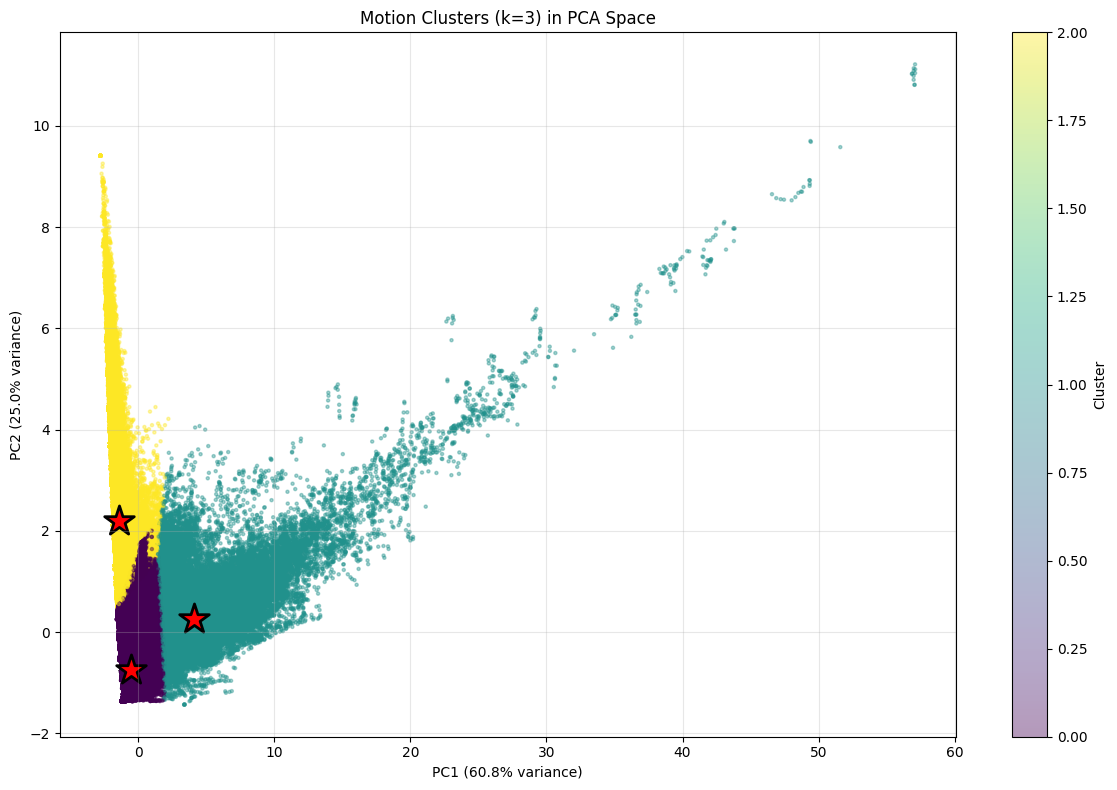


PCA explains 85.8% of variance with 2 components


In [20]:
# Visualize clusters in 2D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_best, 
                     cmap='viridis', alpha=0.4, s=5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title(f'Motion Clusters (k={best_k}) in PCA Space')
plt.grid(True, alpha=0.3)

# Add cluster centers
centers_2d = pca.transform(kmeans_best.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
           marker='*', s=500, c='red', edgecolors='black', linewidth=2)

plt.tight_layout()
plt.savefig(f'motion_clusters_k{best_k}.png', dpi=150)
plt.show()

print(f"\nPCA explains {pca.explained_variance_ratio_.sum():.1%} of variance with 2 components")

In [4]:
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters=k, max_iter=30000)
# kmeans.fit(d.sources)
cluster_ids = kmeans.fit_predict(d.sources)

import numpy as np
from sklearn.metrics import silhouette_score

# sample ~20k points
X = d.sources
idx = np.random.choice(len(X), size=min(20000, len(X)), replace=False)
X_sample = X[idx]
labels_sample = kmeans.labels_[idx]

sil = silhouette_score(X_sample, labels_sample)
print("Silhouette score:", sil)

Silhouette score: 0.80187815


Computing KMeans for k=2...
Computing KMeans for k=3...
Computing KMeans for k=4...
Computing KMeans for k=5...
Computing KMeans for k=6...
Computing KMeans for k=7...
Computing KMeans for k=8...
Computing KMeans for k=9...
Computing KMeans for k=10...


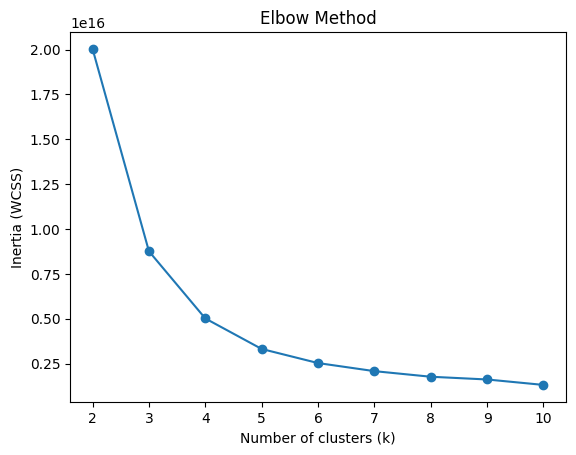

In [59]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def elbow_method(X, k_range):
    inertias = []

    for k in k_range:
        print(f"Computing KMeans for k={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42, max_iter=10000)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)  # this is the WCSS

    return inertias


# Example usage:
k_range = range(2, 11)  # try k = 2,3,...,10
inertias = elbow_method(d.sources, k_range)

plt.plot(k_range, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method")
plt.show()

In [32]:
import numpy as np
from sklearn.metrics import silhouette_score

# sample ~20k points
X = d.sources
idx = np.random.choice(len(X), size=min(20000, len(X)), replace=False)
X_sample = X[idx]
labels_sample = kmeans.labels_[idx]

sil = silhouette_score(X_sample, labels_sample)
print("Silhouette score:", sil)

Silhouette score: 0.08303783


In [23]:
from sklearn.metrics import silhouette_score
sil = silhouette_score(d.sources[:20000], cluster_ids[:20000])
print("Silhouette:", sil)

Silhouette: 0.4775871


In [63]:
import numpy as np

centroids = kmeans.cluster_centers_
distances = np.linalg.norm(X - centroids[kmeans.labels_], axis=1)

print("Mean distance:", distances.mean())
print("Std of distance:", distances.std())

Mean distance: 26571.914
Std of distance: 44588.348


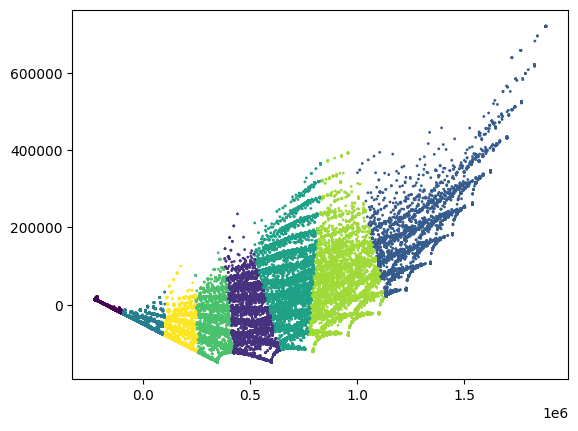

In [64]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

plt.scatter(X2[:,0], X2[:,1], s=1, c=kmeans.labels_)
plt.show()

In [67]:
import umap
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean')
X_umap = reducer.fit_transform(X)

c:\Users\meysam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

In [65]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50,
    min_samples=10,
)

labels = clusterer.fit_predict(X)

c:\Users\meysam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\meysam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [66]:
import numpy as np
num_clusters = len(np.unique(labels[labels != -1]))
noise_fraction = np.mean(labels == -1)

print("Clusters found:", num_clusters)
print("Noise %:", noise_fraction)

Clusters found: 2742
Noise %: 0.4568304130258


In [ ]:
umap.

In [32]:
p2.shape

(1312182, 2)

Text(0.5, 1.0, 'Cluster Visualization')

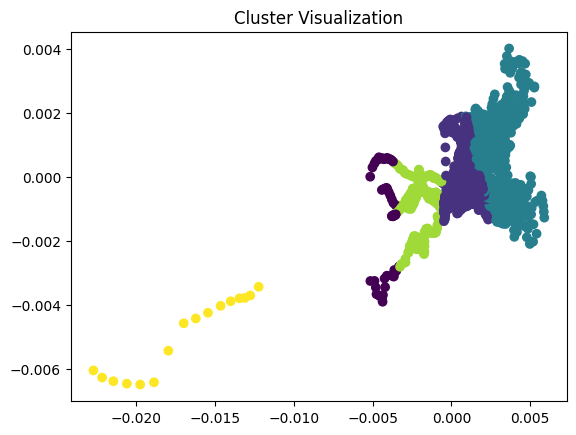

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
p2 = pca.fit_transform(d.sources)[:10000]

plt.scatter(p2[:,0], p2[:,1], c=cluster_ids[:10000])
plt.title("Cluster Visualization")


Silhouette: 0.36961088


In [19]:
d.sources.shape

(1312182, 4)

In [8]:
# def compute_motion_features(bboxes):
#     velocity = np.zeros_like(bboxes)
#     acceleration = np.zeros_like(bboxes)
#     velocity[1:] = np.diff(bboxes, axis=0)
#     acceleration[2:] = np.diff(velocity[1:], axis=0)
#     velocity_center = np.sqrt(velocity[:, 0] ** 2 + velocity[:, 1] ** 2)
#     acceleration_center = np.sqrt(acceleration[:, 0] ** 2 + acceleration[:, 1] ** 2)
#     print(velocity)
#     velocity_mean = velocity_center.mean()
#     velocity_std = velocity_center.std()
#     acceleration_mean = acceleration_center.mean()
#     acceleration_std = acceleration_center.std()
#     return velocity_mean, velocity_std, acceleration_mean, acceleration_std

def compute_motion_features(bboxes):
    velocity = np.zeros_like(bboxes)
    acceleration = np.zeros_like(bboxes)
    velocity[1:] = np.diff(bboxes, axis=0)
    acceleration[2:] = np.diff(velocity[1:], axis=0)
    return np.concat([velocity, acceleration], axis=0)

a = [[0.221875,   0.65763889, 0.1015625,  0.26805556],
 [0.22460938, 0.65833333, 0.09140625, 0.26666667],
 [0.23554687, 0.65833333, 0.08046875, 0.26666667],
 [0.24179687, 0.65763889, 0.07734375, 0.26527778],
 [0.246875,   0.65833333, 0.071875,   0.26388889],
 [0.24609375, 0.65625,    0.065625,   0.26805556],
 [0.24453125, 0.65555556, 0.05625,    0.27777778],
 [0.24492188, 0.65138889, 0.06171875, 0.28611111],
 [0.246875,   0.64722222, 0.0578125,  0.28333333],
 [0.25429687, 0.64583333, 0.06640625, 0.28333333],
 [0.25429687, 0.64652778, 0.07578125, 0.28194444],
 [0.25703125, 0.65,       0.0796875,  0.275    ],
 [0.26328125, 0.64930556, 0.0890625,  0.27361111],
 [0.2671875,  0.65208333, 0.0953125,  0.26805556],
 [0.26875,    0.65347222, 0.1015625,  0.2625    ],
 [0.26601562, 0.65486111, 0.09765625, 0.25972222],
 [0.2625,     0.65416667, 0.0921875,  0.25833333],
 [0.2484375,  0.66111111, 0.0640625,  0.26388889],
 [0.2453125,  0.67083333, 0.0609375,  0.275 ,    ],
 [0.2421875,  0.67916667, 0.0609375,  0.2611111],]

compute_motion_features(a).shape
# np.array(a).shape

(40, 4)

In [4]:
d.sources[0]

array([0.00553565, 0.00365185, 0.00504091, 0.00323391], dtype=float32)

In [11]:
d[0]

(tensor([[0.1711, 0.5236, 0.2727, 0.7917, 1.0000],
         [0.1789, 0.5250, 0.2703, 0.7917, 1.0000],
         [0.1953, 0.5250, 0.2758, 0.7917, 1.0000],
         [0.2010, 0.5253, 0.2805, 0.7917, 0.9671],
         [0.2109, 0.5264, 0.2828, 0.7903, 1.0000],
         [0.2133, 0.5222, 0.2789, 0.7903, 1.0000],
         [0.2164, 0.5167, 0.2727, 0.7944, 1.0000],
         [0.2211, 0.5089, 0.2758, 0.7916, 0.8762],
         [0.1923, 0.5089, 0.2758, 0.7944, 0.6738],
         [0.2134, 0.5040, 0.2875, 0.7840, 0.8862],
         [0.2164, 0.5056, 0.2922, 0.7875, 1.0000],
         [0.2139, 0.5126, 0.2969, 0.7899, 0.9521],
         [0.2106, 0.5211, 0.3078, 0.7843, 0.8840],
         [0.2195, 0.5181, 0.3148, 0.7861, 1.0000],
         [0.2180, 0.5222, 0.3195, 0.7847, 1.0000],
         [0.2172, 0.5250, 0.3148, 0.7847, 1.0000],
         [0.2178, 0.5233, 0.3086, 0.7814, 0.9714],
         [0.2033, 0.5235, 0.2805, 0.7954, 0.8056],
         [0.2148, 0.5333, 0.2758, 0.8083, 1.0000],
         [0.2117, 0.5486, 0.272

In [37]:
a = np.ones(shape=(5,5))
a[1] += a[0]
a[2] += a[1]
a[3] += a[2]
a[4] += a[3]
a[:, 1] += a[:, 0]
a[:, 2] += a[:, 1]
a[:, 3] += a[:, 2]
a[:, 4] += a[:, 3]
# a
np.diag(a)

array([ 1.,  4.,  9., 16., 25.])

In [ ]:
import math, torch, torch.nn as nn
import torch.nn.functional as F
import random
import os

# ---------- positional encoding ----------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                       # (1,L,D)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# ---------- decoder only transformer ----------
class MotionTransformer(nn.Module):
    def __init__(self, input_dim=4, d_model=128, nhead=8,
                 num_layers=3,dim_ff=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.in_fc = nn.Sequential(
            nn.Linear(input_dim, d_model // 4),
            nn.GELU(),
            nn.Linear(d_model // 4, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, d_model)
        )
        # self.in_fc = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.transformer = nn.TransformerDecoder(nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            dim_feedforward=dim_ff,
        ), num_layers=num_layers)
        self.out_fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, d_model // 4),
            nn.GELU(),
            nn.Linear(d_model // 4, input_dim)
        )
        # self.out_fc = nn.Linear(d_model, input_dim)  # predicts offset Δ

    def encode(self, src):
        src_emb = self.pos_enc(self.in_fc(src) * math.sqrt(self.d_model))
        memory = self.transformer.encoder(src_emb)
        return memory

    def decode_step(self, memory, dec_in):
        # dec_in: (B,t,4)
        dec_emb = self.pos_enc(self.in_fc(dec_in) * math.sqrt(self.d_model))
        tgt_mask = self._causal_mask(dec_emb.size(1), device=dec_emb.device)
        out = self.transformer.decoder(dec_emb, memory, tgt_mask=tgt_mask)
        pred_offset = self.out_fc(out[:, -1:, :])     # predict Δ for last step
        return pred_offset

    @staticmethod
    def _causal_mask(size, device):
        return torch.triu(torch.ones(size, size, device=device), diagonal=1).bool()

    # -------- training forward pass with teacher forcing --------
    def forward(self, src, trg, teacher_forcing_ratio=1.0):
        """
        src: (B,S,4) observed boxes
        trg: (B,T,4) future *absolute* boxes
        returns predicted *absolute* boxes for the whole target horizon
        """
        B, T, _ = trg.shape
        memory = self.encode(src)

        # start with the last observed box as initial decoder input
        prev_box = trg[:, 0:1, :]
        # prev_box = src[:, -1:, :]
        preds = []

        for t in range(T):
            offset = self.decode_step(memory, prev_box)

            # compute next box as prev_box + predicted offset
            next_box = trg[:, t:t+1, :] + offset
            # if t == 0:
            #     next_box = src[:, -1:, :] + offset
            # else:
            #     next_box = trg[:, t-1:t, :] + offset
            # next_box = prev_box[:, -1:, :] + offset
            preds.append(next_box)

            if t < T-1:
                # choose next decoder input: ground truth or model prediction
                use_teacher = (random.random() < teacher_forcing_ratio)
                next_in = trg[:, t+1:t+2, :] if use_teacher else next_box
                # next_in = trg[:, t:t+1, :] if use_teacher else next_box
                prev_box = torch.cat([prev_box, next_in], dim=1)

        return torch.cat(preds, dim=1)   # (B,T,4)

    # -------- inference rollout (no teacher forcing) --------
    @torch.no_grad()
    def inference(self, src, trg, num_steps=1):
        memory = self.encode(src)
        prev_box = trg[:, 0:1, :]
        preds = []
        for _ in range(num_steps):
            offset = self.decode_step(memory, prev_box)
            next_box = prev_box[:, -1:, :] + offset
            preds.append(next_box)
            prev_box = torch.cat([prev_box, next_box], dim=1)
        return torch.cat(preds, dim=1)
    
    def train_one_epoch(self, dataloader, optimizer, criterion, teacher_forcing_ratio=0.5, device='cuda'):
        self.train()
        total_loss = 0

        for src, trg in dataloader:
            src = src.to(device)
            trg = trg.to(device)

            optimizer.zero_grad()
            output = self.forward(src, trg[:, :-1], teacher_forcing_ratio)

            loss = criterion(output, trg[:, 1:])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(dataloader)


    def evaluate(self, dataloader, criterion, device='cuda'):
        self.eval()
        total_loss = 0

        with torch.no_grad():
            for src, trg in dataloader:
                src = src.to(device)
                trg = trg.to(device)
                output = self.inference(src, trg, num_steps=trg.size(1) - 1)
                loss = criterion(output, trg[:, 1:])
                total_loss += loss.item()

        return total_loss / len(dataloader)
    
    def save_weight(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(self.state_dict(), path)

    def load_weight(self, path):
        self.load_state_dict(torch.load(path, map_location='cuda', weights_only=True))



d = MotionTransformer().cuda()
d.transformer.forward()

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import random
import configparser

def has_jump(seq):
    return not ((seq[-1]- seq[0] + 1) == len(seq))

class GTSequenceDataset(Dataset):

    @staticmethod
    def load_sequence(seq_path, seq_in_len, seq_out_len, seq_total_len, random_jump, noise):
        sources = []
        targets = []

        gt_path = os.path.join(seq_path, 'gt', 'gt.txt')
        if not os.path.exists(gt_path):
            return [], []
        cfp = configparser.ConfigParser()
        cfp.read(os.path.join(seq_path, 'seqinfo.ini'))
        image_width = np.array(cfp['Sequence']['imWidth']).astype(float)
        image_height = np.array(cfp['Sequence']['imHeight']).astype(float)

        df = pd.read_csv(gt_path, header=None)
        df.columns = ['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'class', 'visibility']

        for obj_id, obj_df in df.groupby('id'):
            obj_df = obj_df.sort_values('frame')
            obj_df['w'] += obj_df['x']
            obj_df['h'] += obj_df['y']
            bboxes = obj_df[['x', 'y', 'w', 'h']].to_numpy().astype(float)
            borders = np.array([image_width, image_height, image_width, image_height]).astype(float)
            if noise:
                bboxes += np.random.randn(bboxes.shape[0], bboxes.shape[1]) * 0.02 * borders
            bboxes /= borders
            frames_total = obj_df['frame'].to_numpy()
            # create sequences of length seq_len
            for i in range(len(bboxes) - seq_total_len): 
                seq = bboxes[i:i+seq_total_len]
                frames = frames_total[i:i+seq_total_len]
                    
                if not random_jump:
                    if has_jump(frames[:seq_in_len]) or has_jump(frames[-seq_out_len:]):
                        continue
                    sources.append(seq[:seq_in_len])
                    targets.append(seq[-seq_out_len:])
                else:
                    index_1 = random.randint(0, int(seq_total_len / 2) - seq_in_len - 1)
                    index_2 = random.randint(0, int(seq_total_len / 2) - seq_in_len - 1)
                    if has_jump(frames[index_1: index_1 + seq_in_len]) or \
                    has_jump(frames[int(seq_total_len / 2) + index_2: int(seq_total_len / 2) + index_2 + seq_out_len:]):
                        continue
                    sources.append(seq[index_1: index_1 + seq_in_len])
                    targets.append(seq[int(seq_total_len / 2) + index_2: int(seq_total_len / 2) + index_2 + seq_out_len:])

        return sources, targets
        return np.array(sources, dtype=np.float32), np.array(targets, dtype=np.float32)


    @classmethod
    def from_sequence(cls, seq_path, seq_in_len=20, seq_out_len=10, seq_total_len=20, random_jump=False, noise=True):
        obj = cls()
        sources, targets = cls.load_sequence(seq_path, seq_in_len, seq_out_len, seq_total_len, random_jump, noise)
        obj.sources = np.array(sources, dtype=np.float32)
        obj.targets = np.array(targets, dtype=np.float32)
        return obj
    

    @classmethod
    def from_roots(cls, root_dirs, seq_in_len=20, seq_out_len=10, seq_total_len=20, random_jump=False, noise=True):
        sources = []
        targets = []

        for root in root_dirs:
            sequences = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
            for seq_path in sequences:
                sources_, targets_ = cls.load_sequence(seq_path, seq_in_len, seq_out_len, seq_total_len, random_jump, noise)
                sources.extend(sources_)
                targets.extend(targets_)

        obj = cls()
        obj.sources = np.array(sources, dtype=np.float32)
        obj.targets = np.array(targets, dtype=np.float32)
        return obj

    
    def __init__(self, root_dirs, seq_in_len=20, seq_out_len=10, seq_total_len=20, random_jump=False, noise=True):
        """
        root_dirs: list of dataset root paths, e.g., ['dancetrack/train', 'mot17/train']
        seq_len: sequence length (e.g., 10 or 20)
        """
        self.sources = []  # will hold all sequences across datasets
        self.targets = []

        for root in root_dirs:
            sequences = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
            for seq_path in sequences:
                gt_path = os.path.join(seq_path, 'gt', 'gt.txt')
                if not os.path.exists(gt_path):
                    continue
                cfp = configparser.ConfigParser()
                cfp.read(os.path.join(seq_path, 'seqinfo.ini'))
                image_width = np.array(cfp['Sequence']['imWidth']).astype(float)
                image_height = np.array(cfp['Sequence']['imHeight']).astype(float)

                df = pd.read_csv(gt_path, header=None)
                df.columns = ['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'class', 'visibility']

                for obj_id, obj_df in df.groupby('id'):
                    obj_df = obj_df.sort_values('frame')
                    obj_df['w'] += obj_df['x']
                    obj_df['h'] += obj_df['y']
                    # obj_df['x'] /= image_width
                    # obj_df['y'] /= np.array(cfp['Sequence']['imHeight']).astype(float)
                    # obj_df['w'] /=np.array(cfp['Sequence']['imWidth']).astype(float)
                    # obj_df['h'] /= np.array(cfp['Sequence']['imHeight']).astype(float)
                    bboxes = obj_df[['x', 'y', 'w', 'h']].to_numpy().astype(float)
                    borders = np.array([image_width, image_height, image_width, image_height]).astype(float)
                    if noise:
                        bboxes += np.random.randn(bboxes.shape[0], bboxes.shape[1]) * 0.02 * borders
                    bboxes /= borders
                    frames_total = obj_df['frame'].to_numpy()
                    # create sequences of length seq_len
                    for i in range(len(bboxes) - seq_total_len): 
                        seq = bboxes[i:i+seq_total_len]
                        frames = frames_total[i:i+seq_total_len]
                            
                        if not random_jump:
                            if has_jump(frames[:seq_in_len]) or has_jump(frames[-seq_out_len:]):
                                continue
                            self.sources.append(seq[:seq_in_len])
                            self.targets.append(seq[-seq_out_len:])
                        else:
                            index_1 = random.randint(0, int(seq_total_len / 2) - seq_in_len - 1)
                            index_2 = random.randint(0, int(seq_total_len / 2) - seq_in_len - 1)
                            if has_jump(frames[index_1: index_1 + seq_in_len]) or \
                            has_jump(frames[int(seq_total_len / 2) + index_2: int(seq_total_len / 2) + index_2 + seq_out_len:]):
                                continue
                            self.sources.append(seq[index_1: index_1 + seq_in_len])
                            self.targets.append(seq[int(seq_total_len / 2) + index_2: int(seq_total_len / 2) + index_2 + seq_out_len:])

        self.sources = np.array(self.sources, dtype=np.float64)
        self.targets = np.array(self.targets, dtype=np.float64)

    def __len__(self):
        return len(self.sources)

    def __getitem__(self, idx):
        source = self.sources[idx]
        target = self.targets[idx]
        return torch.tensor(source), torch.tensor(target)

In [26]:
class A:
    def __init__(self, a):
        self.v = a

class B(A):
    @classmethod
    def from_a(cls, a):
        obj = cls(a)
        obj.v += 1
        return obj
    
    def __init__(self, b):
        super().__init__(b)


b = B.from_a(1)
b.v

2

In [21]:
train_dataset.__getitem__(0)

(tensor([[0.1684, 0.5376, 0.2750, 0.7859],
         [0.1706, 0.5214, 0.2719, 0.7820],
         [0.2146, 0.5433, 0.2712, 0.7676],
         [0.2240, 0.5239, 0.2842, 0.8096],
         [0.2083, 0.5418, 0.2974, 0.8038],
         [0.2543, 0.5347, 0.2616, 0.8008],
         [0.2239, 0.5363, 0.2766, 0.8089],
         [0.2201, 0.5010, 0.2735, 0.7859],
         [0.2334, 0.4998, 0.2691, 0.7878],
         [0.1837, 0.4671, 0.3046, 0.7810]], dtype=torch.float64),
 tensor([[0.1961, 0.5037, 0.3256, 0.8205],
         [0.1703, 0.5457, 0.2598, 0.8390]], dtype=torch.float64))

In [11]:
import numpy as np

# np.random.randn(10, 4)
np.ones((10, 4)) * [1, 2, 3, 4]

array([[1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.]])

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import configparser

class MOTSequenceDataset(Dataset):
    def __init__(self, root_dirs, seq_in_len=20, seq_out_len=10, seq_total_len=20, transform=None):
        """
        root_dirs: list of dataset root paths, e.g., ['dancetrack/train', 'mot17/train']
        seq_len: sequence length (e.g., 10 or 20)
        """
        self.transform = transform
        self.sources = []  # will hold all sequences across datasets
        self.targets = []

        for root in root_dirs:
            sequences = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
            for seq_path in sequences:
                gt_path = os.path.join(seq_path, 'gt', 'gt.txt')
                if not os.path.exists(gt_path):
                    continue
                cfp = configparser.ConfigParser()
                cfp.read(os.path.join(seq_path, 'seqinfo.ini'))
                df = pd.read_csv(gt_path, header=None)
                df.columns = ['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'class', 'visibility']

                # group by object id
                for obj_id, obj_df in df.groupby('id'):
                    obj_df = obj_df.sort_values('frame')
                    obj_df['w'] += obj_df['x']
                    obj_df['h'] += obj_df['y']
                    obj_df['x'] /= np.array(cfp['Sequence']['imWidth']).astype(float)
                    obj_df['y'] /= np.array(cfp['Sequence']['imHeight']).astype(float)
                    obj_df['w'] /=np.array(cfp['Sequence']['imWidth']).astype(float)
                    obj_df['h'] /= np.array(cfp['Sequence']['imHeight']).astype(float)
                    bboxes = obj_df[['x', 'y', 'w', 'h']].to_numpy()
                    # create sequences of length seq_len
                    for i in range(len(bboxes) - seq_total_len):
                        seq = bboxes[i:i+seq_total_len]
                        self.sources.append(seq[:seq_in_len])
                        self.targets.append(seq[-seq_out_len:])

        self.sources = np.array(self.sources, dtype=np.float64)
        self.targets = np.array(self.targets, dtype=np.float64)

    def __len__(self):
        return len(self.sources)

    def __getitem__(self, idx):
        source = self.sources[idx]
        target = self.targets[idx]
        return torch.tensor(source), torch.tensor(target)
    
# -----------------------------
# Create train and val loaders
# -----------------------------
seq_in_len = 10
seq_out_len = 10
seq_total_len = 20
batch_size = 64

base_dir = '../../.Datasets/'

train_dataset = MOTSequenceDataset([
    f'{base_dir}DanceTrack/train',
    f'{base_dir}MOT17/train',
    f'{base_dir}MOT20/train'
], seq_in_len=seq_in_len, seq_out_len=seq_out_len, seq_total_len=seq_total_len)

# seq_in_len = 20
# seq_out_len = 10
# seq_total_len = 20

val_dataset = MOTSequenceDataset([
    f'{base_dir}DanceTrack/val',
    f'{base_dir}MOT17/val',
    f'{base_dir}MOT20/val'
], seq_in_len=seq_in_len, seq_out_len=seq_out_len, seq_total_len=seq_total_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}')

Train samples: 1334544, Val samples: 706702


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

# ----------------------------
# LSTM Seq2Seq for Bounding Box Prediction
# ----------------------------

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=4, middle_dim=16, hidden_dim=64, num_layers=2, dropout=0.2):
        super(LSTMPredictor, self).__init__()

        self.fc_in = nn.Linear(input_dim, middle_dim, dtype=torch.float64)
        self.lstm = nn.LSTM(middle_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, dtype=torch.float64)
        self.fc_out = nn.Linear(hidden_dim, input_dim, dtype=torch.float64)  # predict offset (dx, dy, dw, dh)

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: (batch, seq_len, 4)
        # trg: (batch, seq_len, 4) - ground truth future sequence
        outputs = []
        
        batch_size, trg_size, _ = trg.size()

        out, (hidden, cell) = self.lstm(self.fc_in(src))
        pred = (self.fc_out(out)[:, -1, :] + src[:, -1, :]).unsqueeze(1)
        outputs.append(pred)
    
        for t in range(trg_size - 1):
            use_teacher = random.random() < teacher_forcing_ratio
            input_ = trg[:, t, :].unsqueeze(1) if use_teacher else pred
            out, (hidden, cell) = self.lstm(self.fc_in(input_), (hidden, cell))
            pred = self.fc_out(out) + trg[:, t, :].unsqueeze(1)
            # pred = self.fc_out(out) + input_
            outputs.append(pred)
        outputs = torch.cat(outputs, dim=1)  # (batch, seq_len, 4)
        return outputs
    
    def inference(self, src, num_steps, hidden_=None, cell_=None):
        outputs = []
        if hidden_ is not None and cell_ is not None:
            out, (hidden, cell) = self.lstm(self.fc_in(src), (hidden_, cell_))
        else:
            out, (hidden, cell) = self.lstm(self.fc_in(src))
        pred = (self.fc_out(out)[:, -1, :] + src[:, -1, :]).unsqueeze(1)
        outputs.append(pred)

        for t in range(num_steps - 1):
            out, (hidden, cell) = self.lstm(self.fc_in(pred), (hidden, cell))
            pred = self.fc_out(out) + pred
            outputs.append(pred)
        outputs = torch.cat(outputs, dim=1)  # (batch, seq_len, 4)
        return outputs, (hidden, cell)
        
            

class LossFunction(nn.Module):
    def forward(self, targets, preds):
        bb1 = targets.unsqueeze(2)        # (B, N, 1, 4)
        bb2 = preds.unsqueeze(1)      # (B, 1, N, 4)
        xx1 = torch.maximum(bb1[..., 0], bb2[..., 0])
        yy1 = torch.maximum(bb1[..., 1], bb2[..., 1])
        xx2 = torch.minimum(bb1[..., 2], bb2[..., 2])
        yy2 = torch.minimum(bb1[..., 3], bb2[..., 3])
        w = torch.clamp(xx2 - xx1, min=0)
        h = torch.clamp(yy2 - yy1, min=0)
        inter = w * h
        area1 = (bb1[..., 2] - bb1[..., 0]) * (bb1[..., 3] - bb1[..., 1])
        area2 = (bb2[..., 2] - bb2[..., 0]) * (bb2[..., 3] - bb2[..., 1])
        union = area1 + area2 - inter
        ious = inter / union
        ious = torch.diagonal(ious, dim1=1, dim2=2)
        loss1 = nn.functional.l1_loss(ious, torch.ones_like(ious))
        loss2 = nn.functional.smooth_l1_loss(targets, preds)
        return loss1 + loss2

# ----------------------------
# Training & Evaluation Loops
# ----------------------------

def train_one_epoch(model, dataloader, optimizer, criterion, device, teacher_forcing_ratio=0.5):
    model.train()
    total_loss = 0

    for src, trg in dataloader:
        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for src, trg in dataloader:
            src = src.to(device)
            trg = trg.to(device)
            output = model(src, trg, teacher_forcing_ratio=0)
            loss = criterion(output, trg)
            total_loss += loss.item()

    return total_loss / len(dataloader)


device="cuda"

model = LSTMPredictor(hidden_dim=64, num_layers=4).to(device)
# model.load_state_dict(torch.load('best_lstm_model.pth', map_location='cuda'))
# model.load_state_dict(torch.load('drive/MyDrive/best_lstm_model.pth', map_location='cuda'))
criterion = LossFunction()  

KeyboardInterrupt: 

In [ ]:
# num_epochs = 50
# lr = 1e-3
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
# teacher_forcing_ratio = 1

NUM_EPOCHS = [1, 1, 1, 1, 1, 1]
LRS = [1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4]
TEACHER_FORCING_RATIOS = [1, 0.8, 0.6, 0.4, 0.2, 0]

best_val_loss = float("inf")

for num_epochs, lr, teacher_forcing_ratio in zip(NUM_EPOCHS, LRS, TEACHER_FORCING_RATIOS):


    print(f'Epochs: {num_epochs}  Lr: {lr}  Teacher Forcing Ratio: {teacher_forcing_ratio}')

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, teacher_forcing_ratio)
        val_loss = evaluate(model, val_loader, criterion, device)

        scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_lstm_model.pth")
            # !cp best_lstm_model.pth drive/MyDrive/
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch}: Train Loss = {train_loss:.8f}, Val Loss = {val_loss:.8f}, LR = {current_lr:.8f}")

    print("Training complete. Best Val Loss:", best_val_loss)

In [79]:
a = torch.randn(20,10,4).type(torch.float64).cuda()
b = torch.randn(1,1,4).type(torch.float64).cuda()
model.inference(a, num_steps=20)
# model.forward(a, b).shape

(tensor([[[ 1.3323, -1.3743, -0.0037,  1.3572],
          [ 1.2773, -1.2549, -0.0230,  1.3035],
          [ 1.2223, -1.1335, -0.0414,  1.2539],
          ...,
          [ 0.4581,  0.6574, -0.3658,  0.4098],
          [ 0.4049,  0.7819, -0.3837,  0.3475],
          [ 0.3518,  0.9004, -0.4040,  0.2856]],
 
         [[-1.9520,  0.4306,  0.4768, -0.4266],
          [-2.0061,  0.5480,  0.4567, -0.4835],
          [-2.0623,  0.6642,  0.4373, -0.5447],
          ...,
          [-2.8328,  2.4045,  0.1048, -1.4784],
          [-2.8907,  2.5207,  0.0834, -1.5366],
          [-2.9471,  2.6369,  0.0622, -1.5996]],
 
         [[-0.8855, -0.5869,  1.6400, -0.6110],
          [-0.9394, -0.4729,  1.6199, -0.6681],
          [-0.9910, -0.3591,  1.5985, -0.7243],
          ...,
          [-1.7830,  1.4101,  1.3236, -1.5786],
          [-1.8345,  1.5300,  1.3034, -1.6392],
          [-1.8909,  1.6513,  1.2827, -1.7001]],
 
         ...,
 
         [[ 0.3707,  0.9599, -1.8522,  1.5965],
          [ 0.3140

In [2]:
s, t = next(iter(train_loader))

In [16]:
(t[:, 1:] - t[:, :-1])[0]

tensor([[ 0.0000,  0.0000, -0.0016,  0.0042],
        [-0.0008,  0.0042, -0.0086, -0.0042],
        [-0.0008, -0.0125, -0.0055,  0.0125],
        [-0.0023, -0.0028,  0.0031,  0.0028],
        [-0.0031, -0.0014, -0.0031,  0.0014],
        [-0.0047,  0.0292, -0.0008, -0.0347],
        [-0.0008,  0.0000,  0.0023,  0.0000],
        [-0.0008,  0.0014,  0.0117,  0.0000],
        [ 0.0047,  0.0000,  0.0078,  0.0000]], dtype=torch.float64)

In [14]:
t[0]

tensor([[0.7625, 0.2750, 0.2031, 0.6014],
        [0.7625, 0.2750, 0.2016, 0.6056],
        [0.7617, 0.2792, 0.1930, 0.6014],
        [0.7609, 0.2667, 0.1875, 0.6139],
        [0.7586, 0.2639, 0.1906, 0.6167],
        [0.7555, 0.2625, 0.1875, 0.6181],
        [0.7508, 0.2917, 0.1867, 0.5833],
        [0.7500, 0.2917, 0.1891, 0.5833],
        [0.7492, 0.2931, 0.2008, 0.5833],
        [0.7539, 0.2931, 0.2086, 0.5833]], dtype=torch.float64)